In [63]:
import joblib as joblib
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import roc_auc_score, classification_report
from sklearn.model_selection import train_test_split
import numpy as np

import xgboost as xgb
import ML.utils as ut
import pandas as pd
import joblib

In [64]:
cols_to_drop = joblib.load(f'../data/cols_to_drop')

In [65]:
df = pd.read_csv('../data/train.csv', index_col=0).drop(columns=cols_to_drop)
ID = df['id']
df.drop(['id'], axis=1, inplace=True)

In [66]:
df

,SentMessages,ReceivedMessages,MessagesOutsideWorkHours,SentFrequency,ReceivedFrequency,sent_received_ratio,UniqueRecipients,hidden_copy,carbon_copy,text_length,...,answered_messages,unanswered_messages,unreplied_messages,mention_colleagues,MoodType,StressKeywordsPresent,SalaryChangeMentioned,VacationMentioned,polite_message,Resigned
50,95,92,0,15,38,0.958333,6,1,0,329,...,24,0,5,1,0,0,0,1,0,1
51,73,127,10,13,32,1.716216,8,6,6,427,...,42,0,3,1,0,0,1,1,1,1
52,34,82,0,11,33,2.342857,7,0,1,92,...,16,0,4,1,1,0,1,1,0,1
53,64,126,0,12,34,1.938462,5,2,1,1419,...,27,0,6,1,0,0,0,1,0,1
54,83,84,0,14,31,1.000000,11,1,3,411,...,23,0,3,1,0,0,0,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2995,58,71,8,13,29,1.203390,6,2,1,148,...,22,0,2,1,0,0,0,0,0,0
2996,11,109,0,10,34,9.083333,8,0,2,131,...,16,0,3,1,0,0,0,0,0,0
2997,76,109,0,9,42,1.415584,6,0,2,183,...,20,0,4,1,1,1,1,0,0,0
2998,14,56,1,10,26,3.733333,2,2,0,66,...,38,0,3,1,1,0,0,0,1,0


In [67]:
# Разделяем датасет на X, y
X, y = ut.split_to_x_y(df, 'Resigned')

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

In [69]:
def fit_predict(model, eval_data):
    try:
        model = model(n_jobs=-1)
    except TypeError:
        model = model(random_state=42)
    finally:
        X_train = eval_data['X_train'] if type(eval_data['X_train']) == np.ndarray else eval_data['X_train'].values
        y_train = eval_data['y_train'] if type(eval_data['y_train']) == np.ndarray else eval_data['y_train'].values
        X_test = eval_data['X_test'] if type(eval_data['X_test']) == np.ndarray else eval_data['X_test'].values

        model.fit(X_train, y_train.ravel())
        pred = model.predict(X_test)
        return model, pred

In [70]:
eval_data = {'X_train': X_train, 'X_test': X_test, 'y_train': y_train, 'y_test': y_test}
models = [LogisticRegression, KNeighborsClassifier, SVC, RandomForestClassifier, xgb.XGBClassifier]
max_evals = len(models)
metric = roc_auc_score  # f1_score, roc_auc_score, accuracy_score
metrics = []
fitted_models = []

for model in models:
    model_fitted, pred = fit_predict(model, eval_data)

    metrics.append(metric(eval_data['y_test'].values.ravel(), pred))
    fitted_models.append(model_fitted)

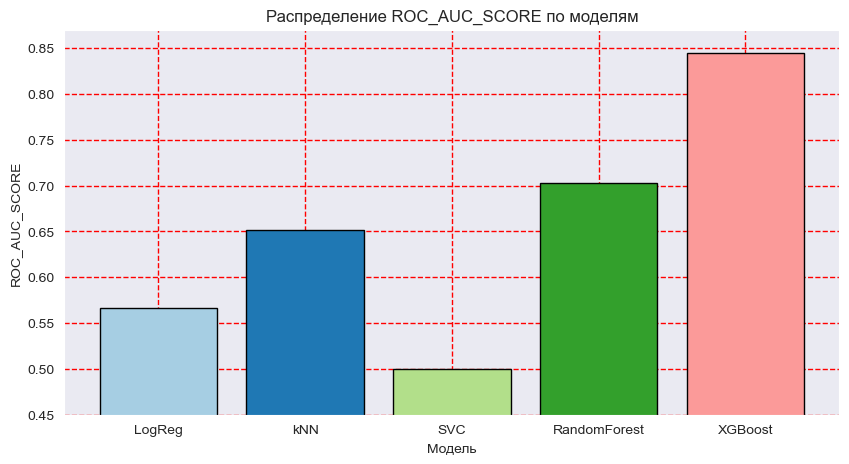

In [71]:
models_names = ['LogReg', 'kNN', 'SVC', 'RandomForest', 'XGBoost']
ut.plot_metrics_hist(models_names, metrics)

In [72]:
best_metric = max(metrics)
best_model_name = models_names[metrics.index(best_metric)]
best_model = fitted_models[metrics.index(best_metric)]

print('Best Model:', best_model_name)
print('Best Metric, ROC_AUC_SCORE:', round(best_metric, 4))
print(classification_report(y_true=y_test, y_pred=best_model.predict(X_test.values)))

Best Model: XGBoost
Best Metric, ROC_AUC_SCORE: 0.8449
              precision    recall  f1-score   support

           0       0.96      0.98      0.97       775
           1       0.84      0.71      0.77       110

    accuracy                           0.95       885
   macro avg       0.90      0.84      0.87       885
weighted avg       0.94      0.95      0.94       885



In [73]:
import joblib

# Сохранение модели в файл
filename = f'../models/{best_model_name}.pkl'
joblib.dump(best_model, filename)

['../models/XGBoost.pkl']